# 2024-2025 Stanley Cup Winner Prediction

The Stanley Cup Playoffs are unpredictable, but are there team statistics that consistently signal who might win? This project explores which advanced playoff stats are most associated with becoming a Stanley Cup Champion.

**Central Question**<br>
Can I identify which team statistics are the strongest predictors of winning the Stanley Cup, and make a prediction about the winning team based off of that? Which of the teams currently competing in the playoffs have the best of those stats, and thus, may me most likely to win?

**General approach**<br>
1. Collected data from the NHL API and NaturalStatTrick.
2. Focused on team-level playoff stats from previous seasons.
3. Used correlation, logistic regression, and gradient boosting to evaluate feature importance.
4. Applied SMOTE to address class imbalance.
5. Isolated key winner-associated features and made a prediction based on that information.


All the necessary files can be found here - https://github.com/hyaneva/IS362_FinalProject <br>
Make sure the script is in the same folder as the files from the datafile folder.

In [36]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import pickle


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from imblearn.over_sampling import SMOTE

## Data gathering

I've commented out the code used to retrieve the data from the NHL API, because I do not want to scrape every time I run the script. One may ask why - and this is because, as I have learned, it is a great and important practice to engage in **responsible and ethical web scraping**. A few good rules I followed are:
1. Make sure you are allowed to scrape data.
2. Only scrape what you need.
3. Throttle requests as to not overload the server (time.sleep)
4. Identify yourself with headers.
5. Web scrape "the right way" - use APIs.

In [ ]:
'''
all_data = []
headers = {
    "User-Agent": "HYanevaNHLPLayoffsPredictor (hyaneva98@gmail.com)"}

for start_year in range(2007, 2024):
    season = int(f"{start_year}{start_year + 1}")
    url = f"https://api.nhle.com/stats/rest/en/team/summary?sort=shotsForPerGame&cayenneExp=seasonId={season}%20and%20gameTypeId=3"

    try:
        r = requests.get(url, headers= headers)
        r.raise_for_status()
        data = r.json().get("data", [])
        for team in data:
            all_data.append({
                "season": season,
                "team": team["teamFullName"],
                "PP_Net%": team["powerPlayNetPct"],
                "PK_Net%": team["penaltyKillNetPct"]
            })
        print(f"Retrieved data for season {season}")
    except Exception as e:
        print(f"Error for season {season}: {e}")
    
    time.sleep(random.randint(1, 3))

df = pd.DataFrame(all_data)
display(df.head())
df.to_csv('PP_PK.csv', index=False) 

'''

The above is just an example of responsible API use. This code was run once and the results were saved to a .CSV file. From this point on, the script will read from the .CSV file instead of making repeated API calls in order to reduce the load on the NHL API.

For the next step, I'm simply reading the PP_PK.csv file I just made back into a new DataFrame in order to avoid continuous requests from the API.
## Source 1: NHL API

In [38]:
pp_pk = pd.read_csv('PP_PK.csv')
display(pp_pk)

,season,team,PP_Net%,PK_Net%
0,20072008,Anaheim Ducks,0.208333,0.736842
1,20072008,Calgary Flames,0.272727,0.806451
2,20072008,Nashville Predators,0.043478,0.884615
3,20072008,Dallas Stars,0.155555,0.828947
4,20072008,Ottawa Senators,0.076923,0.739130
...,...,...,...,...
275,20232024,Los Angeles Kings,0.000000,0.550000
276,20232024,Toronto Maple Leafs,0.047619,0.647058
277,20232024,Florida Panthers,0.123456,0.906666
278,20232024,Colorado Avalanche,0.300000,0.766666


This final project requires  at at least two different types of data sources (e.g., two or more of these: (1) relational, **(2)
scraped web page, (3) web API.**) are used. 


## Source 2: NaturalStatTrick Downloaded .CSVs

I have already used the NHL API as one of my sources, and as for the second source - I will be using https://www.naturalstattrick.com/. The data was directly retrieved from NaturalStattrick, specifically, from the Team > Season Stats (Playoffs at All Strengths) > CSV visible section, where .CSV files are downloadable. These files are named by season:

In [39]:
#These are our files from naturalstattrick, labeled after each season
filenames = [
    '07-08.csv', '08-09.csv', '09-10.csv', '10-11.csv', '11-12.csv', '12-13.csv', 
    '13-14.csv', '14-15.csv', '15-16.csv', '16-17.csv', '17-18.csv', '18-19.csv', 
    '19-20.csv', '20-21.csv', '21-22.csv', '22-23.csv', '23-24.csv'
]

#Load the CSV files into a list of DataFrames
df_list = [pd.read_csv(file) for file in filenames]

#Combines them into a single DataFrame
df = pd.concat(df_list, ignore_index=True)
display(df)

,Unnamed: 0,Team,GP,TOI,W,L,CF,CA,CF%,FF,...,HDCA,HDCF%,HDGF,HDGA,HDGF%,HDSH%,HDSV%,SH%,SV%,PDO
0,1,Boston Bruins,7,431.9167,3,4,448,393,53.27,310,...,84,42.07,8,11,42.11,20.00,82.26,7.50,91.40,0.989
1,2,Montreal Canadiens,12,732.7167,5,7,762,725,51.24,552,...,109,59.02,22,19,53.66,19.30,75.00,8.29,89.49,0.978
2,3,Ottawa Senators,4,240.0000,0,4,214,255,45.63,162,...,58,36.26,4,9,30.77,19.05,80.85,4.46,90.06,0.945
3,4,Pittsburgh Penguins,20,1257.1167,14,6,1048,1245,45.70,812,...,216,51.35,35,25,58.33,19.34,83.33,10.27,92.97,1.032
4,5,Philadelphia Flyers,17,1053.5667,9,8,968,1100,46.81,703,...,198,43.59,30,35,46.15,25.64,76.67,10.22,90.04,1.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,12,Winnipeg Jets,5,300.0000,1,4,306,357,46.15,216,...,73,43.41,7,14,33.33,22.58,73.08,10.64,84.95,0.956
276,13,Nashville Predators,6,361.0333,2,4,333,333,50.00,233,...,59,50.42,5,5,50.00,13.51,84.38,8.11,89.26,0.974
277,14,Vancouver Canucks,13,786.6667,7,6,703,769,47.76,488,...,140,48.34,14,13,51.85,18.92,84.71,12.22,89.74,1.020
278,15,Los Angeles Kings,5,302.1167,1,4,334,290,53.53,220,...,74,43.08,3,10,23.08,8.82,80.77,8.97,85.81,0.948


## Data cleaning and merging

Both DataFrames share the same number of teams in terms of seasons, however the order of the teams is a bit different between both datasets, so adjustments will have to be made. Normally, I would handle missing values, but since the datasets aren't huge, and I've checked them manually, I know there are no missing values. 

In [40]:
'''
Removing unnecessary columns and adding the "season" column from the pp_pk DataFrame to the main df, 
which doesn't include season information. 
Even though the order of teams may differ between the two datasets, 
I can safely align the season data row-wise because both datasets contain exactly one row per team per season. 
This makes sure that, regardless of team order, the number of rows per season matches across both DataFrames.
'''

df = df.drop(columns=["Unnamed: 0"])
df.insert(0, "season", pp_pk["season"].values)

The NHL API and NaturalStattrick have some differences in how they have named certain teams, so that also has to be accounted for. Afterwards, merge the two datasets based on their shared season and Team columns. 

In [41]:
#Standardize column names to match 
pp_pk.rename(columns={"team": "Team"}, inplace=True)

#Standardize any row entries to match as well
pp_pk["Team"] = pp_pk["Team"].replace({
    "Montréal Canadiens": "Montreal Canadiens",
    "St. Louis Blues": "St Louis Blues"
})

In [42]:
#Merge the two DataFrames on both the season and the Team columns
merged_df = df.merge(pp_pk, on=["season", "Team"], how="left")

In [43]:
display(merged_df)

,season,Team,GP,TOI,W,L,CF,CA,CF%,FF,...,HDGF,HDGA,HDGF%,HDSH%,HDSV%,SH%,SV%,PDO,PP_Net%,PK_Net%
0,20072008,Boston Bruins,7,431.9167,3,4,448,393,53.27,310,...,8,11,42.11,20.00,82.26,7.50,91.40,0.989,0.100000,0.939393
1,20072008,Montreal Canadiens,12,732.7167,5,7,762,725,51.24,552,...,22,19,53.66,19.30,75.00,8.29,89.49,0.978,0.109090,0.863636
2,20072008,Ottawa Senators,4,240.0000,0,4,214,255,45.63,162,...,4,9,30.77,19.05,80.85,4.46,90.06,0.945,0.076923,0.739130
3,20072008,Pittsburgh Penguins,20,1257.1167,14,6,1048,1245,45.70,812,...,35,25,58.33,19.34,83.33,10.27,92.97,1.032,0.206521,0.882352
4,20072008,Philadelphia Flyers,17,1053.5667,9,8,968,1100,46.81,703,...,30,35,46.15,25.64,76.67,10.22,90.04,1.003,0.194029,0.786666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,20232024,Winnipeg Jets,5,300.0000,1,4,306,357,46.15,216,...,7,14,33.33,22.58,73.08,10.64,84.95,0.956,0.153846,0.625000
276,20232024,Nashville Predators,6,361.0333,2,4,333,333,50.00,233,...,5,5,50.00,13.51,84.38,8.11,89.26,0.974,0.090909,0.846153
277,20232024,Vancouver Canucks,13,786.6667,7,6,703,769,47.76,488,...,14,13,51.85,18.92,84.71,12.22,89.74,1.020,0.138888,0.809523
278,20232024,Los Angeles Kings,5,302.1167,1,4,334,290,53.53,220,...,3,10,23.08,8.82,80.77,8.97,85.81,0.948,0.000000,0.550000


# Predicting Stanley Cup Winners Based on Team Statistics

One of the project requirements was to perform a data transformation. For this, I created a new binary target column called Cup_Winner, which flags whether a given team won the Stanley Cup in a particular season.

To do this, I created a dictionary of past Stanley Cup champions, where the keys are season identifiers, and the values are the corresponding winning teams. Using this dictionary, I added a new column to the DataFrame with a 1 if the team won that season, and a 0 otherwise.

In [44]:
cup_winners = {
    20072008: "Detroit Red Wings",
    20082009: "Pittsburgh Penguins",
    20092010: "Chicago Blackhawks",
    20102011: "Boston Bruins",
    20112012: "Los Angeles Kings",
    20122013: "Chicago Blackhawks",
    20132014: "Los Angeles Kings",
    20142015: "Chicago Blackhawks",
    20152016: "Pittsburgh Penguins",
    20162017: "Pittsburgh Penguins",
    20172018: "Washington Capitals",
    20182019: "St Louis Blues",
    20192020: "Tampa Bay Lightning",
    20202021: "Tampa Bay Lightning",
    20212022: "Colorado Avalanche",
    20222023: "Vegas Golden Knights",
    20232024: "Florida Panthers",
   
}


merged_df["Cup_Winner"] = merged_df.apply(
    lambda row: 1 if row["Team"] == cup_winners.get(row["season"]) else 0,
    axis=1
)

---
# Data preparation and preprocessing

I need to figure out if there are any non-numerical or irrelevant categories left and either drop or transform them. 
Since all meaningful features were already numeric, encoding was not necessary. However, I dropped a few columns (leaky features) that could bias the model:
1. Team: Text column, not useful for prediction
2. Season: Just an identifier, not a feature
3. W / L (Wins and Losses): Including these would give the model an unfair advantage since the Cup winner by definition has the most playoff wins, leaky.
4. Games played (GP), leaky
5. Time on ice (TOI), leaky

In [45]:
#Making a copy of the DataFrame since I will be dropping and transforming certain information
new_df = merged_df.copy()

In [46]:
#Drop the non-numeric and irrelevant columns
new_df = new_df.drop(columns=['Team', 'season', 'W','L', 'GP', 'TOI'])

## Find Top 7 Stats via Correlation
Next, I computed Pearson correlations between each stat and the Cup_Winner stat, then selected the 7 with the strongest absolute correlation. This step will help narrow the feature set to the most relevant predictors - those that move most closely with winning. 

Since later on, I will be modeling on a combination of features (not only just one at a time), it will be more efficient to start with a small set than to search blindly through dozens of variables hoping to find the needle in a haystack. And, doing otherwise might make my computer crash.

It's important to note that correlation does not imply causation - these stats may be associated with winning, but that doesn't prove they directly cause it. Proving that is going to extend beyond the scope of this project.

In [47]:
top7 = new_df.corr()['Cup_Winner'].drop('Cup_Winner').abs().sort_values(ascending=False).head(7)
top7_features = top7.index.tolist()
print("Top 7 Features by Correlation:\n", top7)

Top 7 Features by Correlation:
 GF      0.558101
HDGF    0.554689
SF      0.533519
FF      0.527280
SCF     0.521253
CF      0.517087
xGF     0.512896
Name: Cup_Winner, dtype: float64


Some context for the top 7 features that appear to most correlate with being a winner:
1. **GF (Goals for):** The total number of goals scored by a team, indicating offensive success.
2. **HDGF (High Danger Goals For):** The number of goals scored from high-danger areas, showing a team’s efficiency in converting prime scoring opportunities.
3. **SF (Shots For):** The total number of shots taken by a team, reflecting offensive pressure and scoring potential.
4. **FF (Fenwick For):** The total number of unblocked shots a team takes, measuring puck possession and offensive zone control.
5. **SCF (Scoring Chances For):** The number of scoring chances a team generates, indicating the quality of their offensive plays.
6. **CF (Corsi For):** The total number of shot attempts (on goal, missed, or blocked) a team generates, showing overall possession and offensive dominance.
7. **xGF (Expected Goals For):** An estimate of the likelihood that a team’s shots will result in goals, accounting for shot quality and context.


The correlation analysis suggests that offensive metrics, particularly **GF** and **HDGF**, are the most strongly associated with Stanley Cup victories. These findings indicate that teams with higher offensive production and more high-danger scoring chances tend to perform better in the playoffs. Logically, this does make sense as naturally teams that score more are more likely to win, but even more 'obvious' conclusions deserve to be backed by data. Therefore, these are features worth looking at.

This heatmap below is the accompanying visual for the correlation analysis.

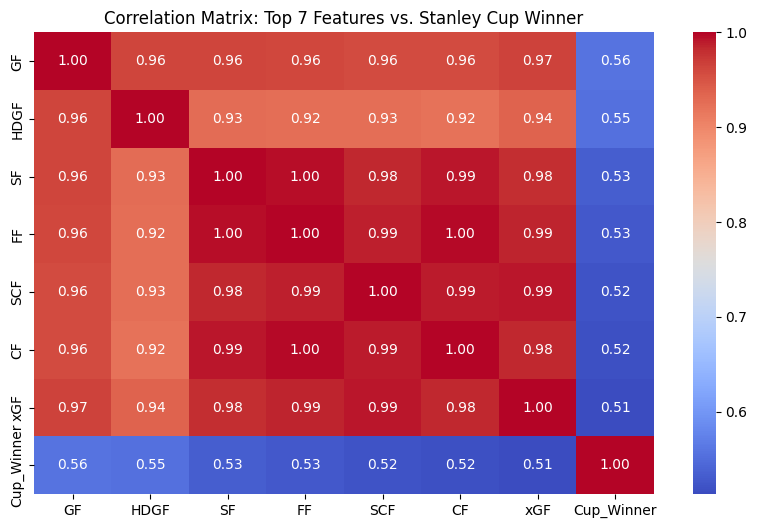

In [48]:
#Correlation heatmap for the top 7 features + the Winner target
top7_df = new_df[top7_features + ['Cup_Winner']]
plt.figure(figsize=(10,6))
sns.heatmap(top7_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Top 7 Features vs. Stanley Cup Winner")
plt.show()

---

# Using Logistic Regression and Gradient Boosting

## Individual Feature Performance

After isolating the top 7 features most correlated with Stanley Cup wins, I will train two models on several different combinations:

1. **Logistic Regression** for simplicity and interpretability.

2. **Gradient Boosting** for capturing complex patterns.

Since Cup winners are rare (only 1 per season), meaning they are underrepresented in the dataset. I will use SMOTE on the training data to balance out the class distribution. SMOTE creates synthetic data in the minority class(our Stanley cup winner). To fairly compare the models, I will also make a summary report on precision, recall, F1-score, and ROC AUC, not just raw accuracy. 

This section evaluates each of the top 7 features on its own. By isolating them, I can better understand which single stat is the most predictive.

Please note that these models are intentionally simple, each using only one feature. This helps isolate the impact of individual stats.

In [49]:
#Store summary rows for the condensed presentation of results
summary_rows = []

for feat in top7_features:
    X = new_df[[feat]] #target
    y = new_df['Cup_Winner'] #feature
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

    #Apply SMOTE to training set
    smote = SMOTE(random_state=1)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    #Standardizes the single feature
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sm)
    X_test_scaled = scaler.transform(X_test)

    #Logistic Regression
    log_clf = LogisticRegression(class_weight='balanced', random_state=1)
    log_clf.fit(X_train_scaled, y_train_sm) #Uses the scaled training data
    log_preds = log_clf.predict(X_test_scaled) #Predict win or no
    log_proba = log_clf.predict_proba(X_test_scaled)[:, 1] #How certain model is in its prediction
    log_auc = roc_auc_score(y_test, log_proba)
    log_report = classification_report(y_test, log_preds, output_dict=True)['1']

    #Gradient Boosting
    gbm_clf = GradientBoostingClassifier(random_state=1)
    gbm_clf.fit(X_train_sm, y_train_sm)
    gbm_preds = gbm_clf.predict(X_test) #Predict win or no
    gbm_proba = gbm_clf.predict_proba(X_test)[:, 1] #How certain model is in its prediction
    gbm_auc = roc_auc_score(y_test, gbm_proba)
    gbm_report = classification_report(y_test, gbm_preds, output_dict=True)['1']

    #Append both models' results
    summary_rows.append({
        'Feature': feat,
        'Model': 'LogReg',
        'Precision': log_report['precision'],
        'Recall': log_report['recall'],
        'F1-Score': log_report['f1-score'],
        'ROC AUC': log_auc
    })

    summary_rows.append({
        'Feature': feat,
        'Model': 'GBM',
        'Precision': gbm_report['precision'],
        'Recall': gbm_report['recall'],
        'F1-Score': gbm_report['f1-score'],
        'ROC AUC': gbm_auc
    })

#Creates summary DataFrame
summary_df = pd.DataFrame(summary_rows)
#Sorted summary DataFrame
summary_df = summary_df.sort_values(by=['ROC AUC', 'F1-Score', 'Recall', 'Precision'], ascending=False).reset_index(drop=True)

print("Individual feature performance:")
display(summary_df)

Individual feature performance:


,Feature,Model,Precision,Recall,F1-Score,ROC AUC
0,HDGF,LogReg,0.454545,1.0,0.625000,0.981013
1,xGF,LogReg,0.384615,1.0,0.555556,0.979747
2,GF,LogReg,0.444444,0.8,0.571429,0.977215
3,FF,GBM,0.571429,0.8,0.666667,0.975949
4,FF,LogReg,0.500000,1.0,0.666667,0.974684
5,SF,LogReg,0.400000,0.8,0.533333,0.974684
6,SCF,LogReg,0.400000,0.8,0.533333,0.969620
7,CF,LogReg,0.454545,1.0,0.625000,0.967089
8,xGF,GBM,0.500000,0.8,0.615385,0.960759
9,CF,GBM,0.444444,0.8,0.571429,0.958228


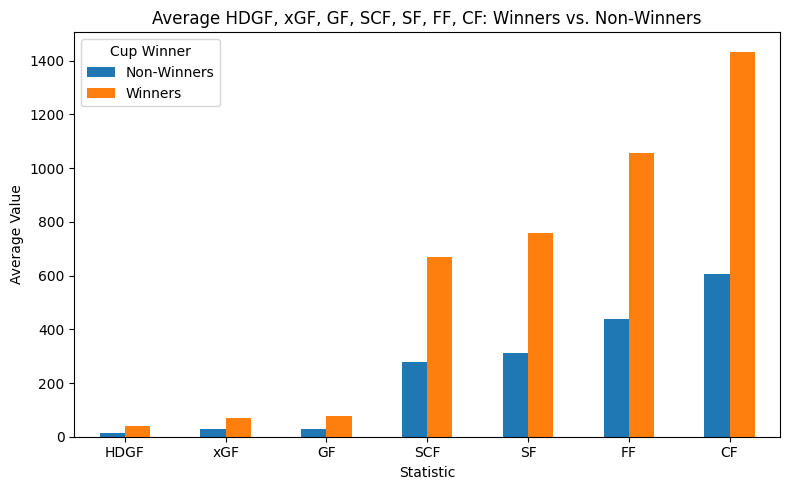

In [50]:
#Compute means grouped by Cup_Winner
means = new_df.groupby('Cup_Winner')[['SF','FF','xGF', 'GF', 'HDGF', 'SCF', 'CF']].mean().T
means_sorted = means.sort_values(by=1, ascending=True)
#Plot
means_sorted.plot(kind='bar', figsize=(8,5))
plt.xticks(rotation=0)
plt.xlabel('Statistic')
plt.ylabel('Average Value')
plt.title('Average HDGF, xGF, GF, SCF, SF, FF, CF: Winners vs. Non‑Winners')
plt.legend(['Non‑Winners','Winners'], title='Cup Winner')
plt.tight_layout()
plt.show()

The bar chart above compares the average values of each top statistic for Stanley Cup champions versus other playoff teams. For every metric - from HDGF down to CF - winners outperform their peers. In particular, the largest gaps appear in GF, HDGF, and xGF, highlighting that actual goal production and high‑quality scoring chances are key differentiators. This straightforward comparison reinforces that these metrics reliably separate champions from the rest.

***Hint: The colors of the chart are actually the colors of the team that's the predicted winner!***

### More insights for individual feature performance

In order to understand which metric is more important (ROC AUC/F1-Score), it needs to be established what they actually represent.
ROC AUC - Shows how well a model separates winners from non-winners across all thresholds. 
F1-Score - Balances precision (how many predicted winners are correct) and recall (how many actual winners are identified).

In other words,

**ROC AUC = “Who’s most likely to win?”<br>
F1 Score = “Who will actually win?”**


Overall, certain features consistently stood out across models. For instance, GF and FF, just like in the correlation analysis, proved to be one of the most reliable single predictors, achieving strong F1-scores and high ROC AUC values, especially with GBM. 

Other features like **HDGF and xGF** performed well in Logistic Regression, often achieving perfect recall, meaning they correctly identified all true Stanley Cup winners. However, these same features tended to suffer from low precision, suggesting that the model overpredicted winners when relying on them alone, i.e. flagged false positives. This shows how certain features might be too optimistic when used in isolation, and why combining high-recall and high-precision features can provide more balanced predictive power.

Gradient Boosting using **GF** yielded the highest F1‑score (0.73) and precision (0.67), showing raw goal output is overall the strongest lone predictor for accurately identifying champions. **FF** offered the most balanced performance across both models, with F1 at 0.67 and ROC AUC at 0.976, indicating unblocked shot attempts reliably separate winners from non‑winners as a lone stat. 

**Taken together, this suggests that championship teams must excel at both dominating puck possession (high FF/CF) and consistently creating high‑value scoring opportunities (high HDGF/xGF). Shot volume (SF) is also indicative of success. In practice, focusing solely on one dimension is unlikely to guarantee success; the best playoff contenders mix offensive volume with shot‑quality (and defensive stats!) to maximize their chances of winning.**

---

## Multi-feature performance

To evaluate how different combinations of team stats impact the ability to predict Stanley Cup winners, I generated all possible non-empty combinations of the 7 selected features with the itertools module. This resulted in a total of 127 unique combinations, ranging from single-feature models (which was already done above) to one using all seven. As I'm training on both Logistic Regression and GBM - I expect 254 entries.

The rest of the procedure was the exact same as the individual feature models.

Finally, the results were stored in a DataFrame and sorted in two ways: once by ROC AUC (to emphasize the model's ranking ability), and once by F1-Score (to prioritize balanced classification performance). This helped reveal the most effective feature combinations for both model types.

In [51]:
#The 7 features I chose
features = ['GF', 'HDGF', 'SF', 'FF', 'SCF', 'CF', 'xGF']

#Create a dictionary of all non-empty combinations
feature_combinations = {}

for r in range(1, len(features) + 1):  #from 1-feature to 7-feature combos
    for combo in combinations(features, r):
        key = '_'.join(combo)
        feature_combinations[key] = list(combo)

In [52]:
#Store results
results = []

#Loop through each combination
for label, features in feature_combinations.items():
    
    X = new_df[features]
    y = new_df['Cup_Winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
    
    #Apply SMOTE to training set
    smote = SMOTE(random_state=1)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    #Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sm)
    X_test_scaled = scaler.transform(X_test)

    #Logistic Regression
    log_clf = LogisticRegression(class_weight='balanced', random_state=1)
    log_clf.fit(X_train_scaled, y_train_sm)
    log_preds = log_clf.predict(X_test_scaled)
    log_proba = log_clf.predict_proba(X_test_scaled)[:, 1]
    log_report = classification_report(y_test, log_preds, output_dict=True)
    log_auc = roc_auc_score(y_test, log_proba)
    results.append({
        'Combo': label,
        'Model': 'LogReg',
        'Precision': log_report['1']['precision'],
        'Recall': log_report['1']['recall'],
        'F1-Score': log_report['1']['f1-score'],
        'ROC AUC': log_auc
    })

    #Gradient Boosting
    gbm_clf = GradientBoostingClassifier(random_state=1)
    gbm_clf.fit(X_train_sm, y_train_sm)
    gbm_preds = gbm_clf.predict(X_test)
    gbm_proba = gbm_clf.predict_proba(X_test)[:, 1]
    gbm_report = classification_report(y_test, gbm_preds, output_dict=True)
    gbm_auc = roc_auc_score(y_test, gbm_proba)
    results.append({
        'Combo': label,
        'Model': 'GBM',
        'Precision': gbm_report['1']['precision'],
        'Recall': gbm_report['1']['recall'],
        'F1-Score': gbm_report['1']['f1-score'],
        'ROC AUC': gbm_auc
    })

In [53]:
#Convert to DataFrame
results_df = pd.DataFrame(results)

## Multi-feature results sorted by ROC AUC

In [54]:
#Sort by ROC AUC
print("Top 10 results sorted by ROC AUC:")
df_ROCAUC = results_df.sort_values(by=['ROC AUC', 'F1-Score', 'Recall', 'Precision'], ascending=False).round(3)
display(df_ROCAUC.head(10))

Top 10 results sorted by ROC AUC:


,Combo,Model,Precision,Recall,F1-Score,ROC AUC
123,FF_CF_xGF,GBM,0.714,1.0,0.833,1.000
221,GF_SF_FF_CF_xGF,GBM,0.800,0.8,0.800,0.992
213,GF_HDGF_FF_CF_xGF,GBM,0.667,0.8,0.727,0.991
111,SF_FF_xGF,GBM,1.000,0.8,0.889,0.990
58,GF_HDGF_FF,LogReg,0.571,0.8,0.667,0.990
62,GF_HDGF_CF,LogReg,0.571,0.8,0.667,0.990
208,GF_HDGF_FF_SCF_CF,LogReg,0.571,0.8,0.667,0.990
92,HDGF_SF_xGF,LogReg,0.500,0.8,0.615,0.990
94,HDGF_FF_SCF,LogReg,0.500,0.8,0.615,0.990
100,HDGF_SCF_CF,LogReg,0.500,0.8,0.615,0.990


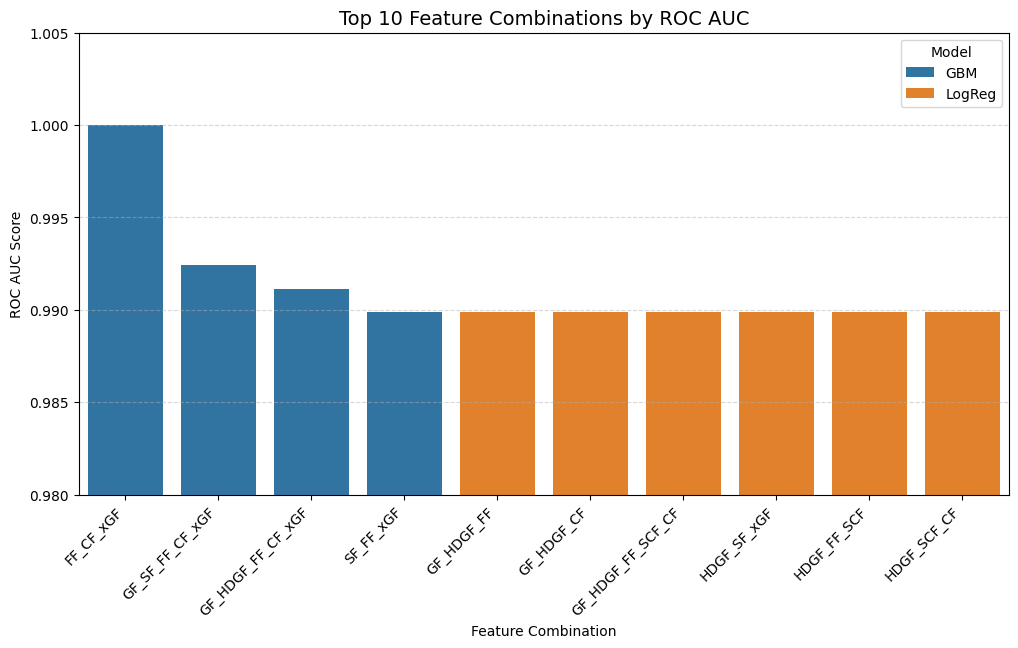

In [55]:
#Top 10 results sorted by ROC AUC
top_rocauc = results_df.sort_values(by=['ROC AUC', 'F1-Score', 'Recall', 'Precision'], ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_rocauc, x='Combo', y='ROC AUC', hue='Model', dodge=False)

plt.title('Top 10 Feature Combinations by ROC AUC', fontsize=14)
plt.xlabel('Feature Combination')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.98, 1.005)  #Zoomed in to make difference obv
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Multi-feature results sorted by F1-Score

In [56]:
#Sort by F1-Score
print("Top 10 results sorted by F1-Score:")
df_f1 = results_df.sort_values(by=['F1-Score', 'ROC AUC', 'Recall', 'Precision'], ascending=False).round(3)
display(df_f1.head(10))

Top 10 results sorted by F1-Score:


,Combo,Model,Precision,Recall,F1-Score,ROC AUC
47,FF_CF,GBM,0.833,1.0,0.909,0.987
111,SF_FF_xGF,GBM,1.000,0.8,0.889,0.990
169,HDGF_SF_FF_CF,GBM,1.000,0.8,0.889,0.987
123,FF_CF_xGF,GBM,0.714,1.0,0.833,1.000
221,GF_SF_FF_CF_xGF,GBM,0.800,0.8,0.800,0.992
183,HDGF_FF_CF_xGF,GBM,0.800,0.8,0.800,0.987
199,GF_HDGF_SF_FF_CF,GBM,0.800,0.8,0.800,0.987
191,SF_FF_CF_xGF,GBM,0.800,0.8,0.800,0.987
109,SF_FF_CF,GBM,0.800,0.8,0.800,0.985
231,HDGF_SF_FF_CF_xGF,GBM,0.800,0.8,0.800,0.985


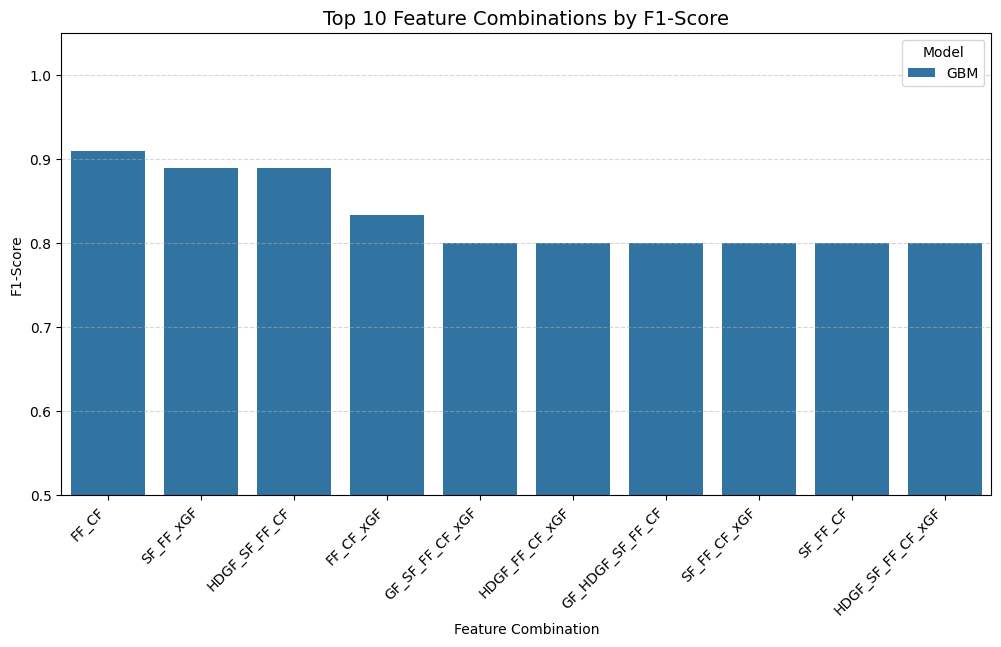

In [57]:
#Top 10 results sorted by F1-Score
top_f1 = results_df.sort_values(by=['F1-Score', 'ROC AUC', 'Recall', 'Precision'], ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_f1, x='Combo', y='F1-Score', hue='Model', dodge=False)

plt.title('Top 10 Feature Combinations by F1-Score', fontsize=14)
plt.xlabel('Feature Combination')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.05)  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

---

### Insights for Multi-feature Performance

**Model insights:**<br>
The best performing model overall was a Gradient Boosting Model (GBM) trained on the feature combination FF, CF, xGF, which achieved a ROC AUC: 1.000, F1-Score: 0.833, Recall: 1.0, Precision: 0.714.

It's important to keep in mind that F1-Score can be skewed by either a high precision or recall. Several other GBM models with combinations like GF, SF, FF, CF, xGF and GF, HDGF, FF, CF, xGF also scored ROC AUC values above 0.99, showing that GBM consistently outperformed Logistic Regression on top combinations. However, GBM's performance was also more spread out across the spectrum, with the worst-performing models also being GBM.

Despite not topping the chart, Logistic Regression still performed strongly, with several combinations reaching ROC AUC = 0.990, especially those involving HDGF and combinations of SCF, CF, xGF.These models typically had high recall (0.8-1.0) but lower precision (0.4-0.5), indicating they were good at identifying true positives (potential winners) but may also flag more false positives.

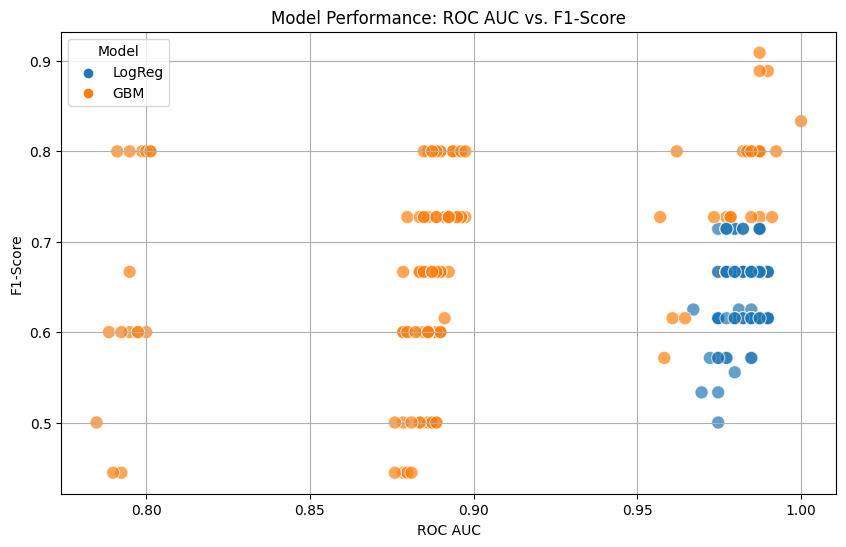

In [58]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='ROC AUC', y='F1-Score', hue='Model', alpha=0.7, s=90)
plt.title('Model Performance: ROC AUC vs. F1-Score')
plt.xlabel('ROC AUC')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

The scatterplot above shows the trade-off between AUC and F1 for all combos, and the GBM vs. Logistic Regression clusters. 
GBM models show a wide spread of performance, indicating they capture diverse patterns and have varying trade-offs between ranking ability and balanced classification. Meanwhile, Logistic Regression models cluster more tightly, meaning they have a simpler and more consistent, but less flexible performance across feature combinations. This suggests GBMs can adapt better to complex relationships, while Logistic Regression offers steadier but less variable results.

On the other hand, the UpSet plot below visualizes the overlap of features used in the top 10 performing stat combinations (ranked by ROC AUC and F1-Score). It highlights which individual stats and stat groupings most frequently appear together in the best-performing models.

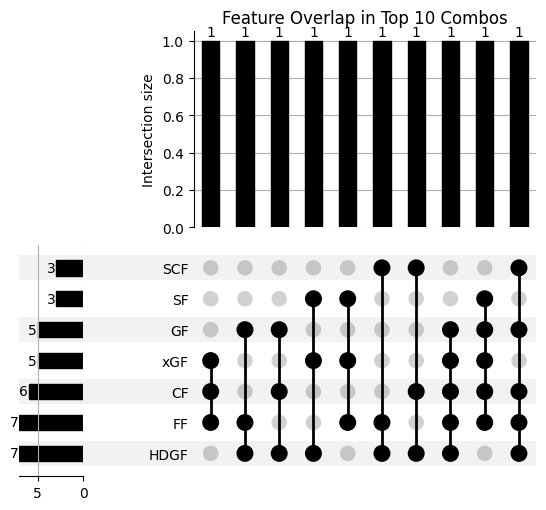

In [59]:
from upsetplot import UpSet, from_memberships

# Get top N combos
top_combos = results_df.sort_values(by=['ROC AUC','F1-Score'], ascending=False).head(10)

# Convert to sets
memberships = [combo.split('_') for combo in top_combos['Combo']]
data = from_memberships(memberships)

# Plot
UpSet(data, show_counts=True).plot()
plt.title('Feature Overlap in Top 10 Combos')
plt.show()

**Features Insights:**<br>
**FF and CF** appear in almost all of the top combinations, suggesting these shot attempt metrics are highly predictive of Stanley Cup success. **xGF** also shows up frequently in top models, also showing itself as a high-signal metric in playoff performance. **HDGF** improves performance, but seems to not be essential for top results, as models without it still perform at elite levels if FF, CF, and xGF are present. However, at teh same time, HDGF does reflect a team’s ability to finish in prime scoring areas - a skill that playoff champions consistently demonstrate.



**GBM vs Logistic Regression:**<br>
Gradient Boosting Models overall have the highest ROC AUC and F1-Score, with more balanced precision/recall tradeoffs. Logistic Regression often achieves high recall but suffers from lower precision, making it potentially less reliable for high-confidence predictions in this particular binary classification project (winner vs. non-winner).<br> Additionally, models using only 3 to 4 features often rival or outperform those using 6 or more, which indicates that perhaps more features do not equal better performance (in this case). This is especially important given the class imbalance of the dataset - simpler, well-selected features (like FF, CF, xGF) help the model stay focused on signal rather than noise.

---
### Final Model Selection and Use Cases

**In order to be able to predict 2025's Stanley Cup winner, I'll pick the top 3 models from each ranking, based on different metrics:**<br>

| Model Combo      | Optimized For | Precision | Recall | F1 Score | ROC AUC | Best Use |
|------------------|---------------|-----------|--------|----------|---------|----------|
| FF_CF_xGF (GBM)  | ROC AUC       | 0.714     | 1.00   | 0.833    | **1.000** | Ranking teams by likelihood of winning |
| FF_CF (GBM)      | F1 Score      | 0.833     | **1.00** | **0.909**  | 0.987   | Predicting if a team will win (high recall) |
| SF_FF_xGF (GBM)  | F1 Score      | **1.000** | 0.80   | 0.889    | 0.990   | Confidently picking a team (high precision) |

Again, each model serves a unique purpose. High ROC AUC is used to rank team probabilities, high F1/Recall helps catch the actual winner, and high Precision avoids false positives.

---

## Applying findings to 2025 Playoff Data

As of May 13th, 2025, we are in the middle of the NHL playoffs, so the 2025 data is of course, partial and limited. To evaluate team performance, I focused on the three top-performing feature combinations identified during model training: FF_CF_xGF, FF_CF, and SF_FF_xGF.

Instead of relying on full model predictions, I took the 2025 data, standardized and combined these key features for each team to create composite scores that rank their relative playoff strength. This way I can get an interpretable ranking based on the most predictive metrics, and avoid issues with low-confidence binary classifications due to my limited data.

The 2025 data was preprocessed by filtering to exclude eliminated teams. Since the top 7 features I isolated weren't the ones present in the NHL API data, I only needed the NaturalStattrick data.

In [60]:
#Importing and preprocessing the 2025 data
data_2025 = pd.read_csv("24-25.csv")
data_2025.insert(0, "season", 20242025)
data_2025 = data_2025.drop(columns=["Unnamed: 0"])

#Filters data_2025 to exclude the eliminated teams
eliminated_teams = ['Ottawa Senators', 'Tampa Bay Lightning', 'Montreal Canadiens', 
                    'New Jersey Devils', 'St Louis Blues', 'Colorado Avalanche', 
                    'Minnesota Wild', 'Los Angeles Kings']  

filter_2025 = data_2025[~data_2025['Team'].isin(eliminated_teams)].copy()

print("The 2025 NHL Playoffs data as of 05/13/2025")
display(filter_2025)

The 2025 NHL Playoffs data as of 05/13/2025


,season,Team,GP,TOI,W,L,CF,CA,CF%,FF,...,HDCA,HDCF%,HDGF,HDGA,HDGF%,HDSH%,HDSV%,SH%,SV%,PDO
1,20242025,Toronto Maple Leafs,10,637.6167,6,4,536,689,43.76,404,...,125,47.48,14,15,48.28,20.00,79.17,12.55,89.05,1.016
2,20242025,Florida Panthers,9,555.4500,6,3,581,485,54.50,404,...,95,54.55,17,14,54.84,25.76,76.27,12.79,88.43,1.012
5,20242025,Washington Capitals,9,545.5333,5,4,465,672,40.90,349,...,99,53.08,9,9,50.00,13.24,82.35,11.11,91.24,1.024
7,20242025,Carolina Hurricanes,9,589.9833,7,2,745,492,60.23,513,...,111,53.75,8,6,57.14,11.43,90.32,10.03,92.31,1.023
9,20242025,Winnipeg Jets,10,636.1667,5,5,643,550,53.90,469,...,107,54.66,16,15,51.61,20.51,76.56,10.51,85.23,0.957
11,20242025,Dallas Stars,10,623.2833,6,4,574,720,44.36,403,...,137,47.31,9,15,37.50,13.04,81.93,11.28,90.06,1.013
13,20242025,Vegas Golden Knights,10,636.8500,5,5,699,643,52.09,467,...,122,48.31,12,16,42.86,20.00,76.12,9.69,87.41,0.971
14,20242025,Edmonton Oilers,10,633.6333,7,3,717,630,53.23,509,...,108,59.70,22,15,59.46,25.29,76.56,12.84,87.64,1.005


In [61]:
#Define the 3 feature combos that were isolated
feature_combos = {
    "FF_CF_xGF_score": ["FF", "CF", "xGF"],
    "FF_CF_score": ["FF", "CF"],
    "SF_FF_xGF_score": ["SF", "FF", "xGF"]
}

filter_2025 = filter_2025.copy()

#Loop through the 3 combos, scale features, create composite score by aggregating
for score_name, features in feature_combos.items():
    X = filter_2025[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    filter_2025[score_name] = X_scaled.mean(axis=1)

#Display top 5 teams for each score
for score_name in feature_combos.keys():
    print(f"\nTop 5 teams by {score_name}:")
    ranked = filter_2025[["Team", score_name]].sort_values(score_name, ascending=False)
    print(ranked.head(5))


Top 5 teams by FF_CF_xGF_score:
                    Team  FF_CF_xGF_score
14       Edmonton Oilers         1.419213
7    Carolina Hurricanes         1.273002
9          Winnipeg Jets         0.262788
13  Vegas Golden Knights         0.235315
11          Dallas Stars        -0.280590

Top 5 teams by FF_CF_score:
                    Team  FF_CF_score
7    Carolina Hurricanes     1.355452
14       Edmonton Oilers     1.165333
13  Vegas Golden Knights     0.682440
9          Winnipeg Jets     0.393677
2       Florida Panthers    -0.540867

Top 5 teams by SF_FF_xGF_score:
                    Team  SF_FF_xGF_score
14       Edmonton Oilers         1.612053
7    Carolina Hurricanes         1.179740
9          Winnipeg Jets         0.205510
13  Vegas Golden Knights         0.106039
11          Dallas Stars        -0.279600


---
## Conclusion

Across all three composite‐score methods, two teams are consistently at the top:<br>**The Edmonton Oilers and the Carolina Hurricanes**

This kind of consistency suggests both teams excel across multiple dimensions - puck possession (FF, CF), shot volume (SF), and shot quality (xGF).<br>The Winnipeg Jets and Vegas Golden Knights both land in the 3rd-4th spots consistently, indicating they’re solid but not quite at the level of the top two. As of May 14th, the Knights have been officially eliminated, but the data available does not reflect that yet, unfortunately.<br>Dallas Stars appear in the bottom half of the top five (5th place) when the shot volume (SF) is included or when using the three‑stat combo, signaling a relative weakness in expected goals or shot generation.

FF_CF_xGF_score slightly favors Edmonton over Carolina (1.42 vs. 1.27), it shows Edmonton’s league‑leading expected goals rates. 

FF_CF_score is flipped - Hurricanes over the Oilers (1.36 vs. 1.17), showing Carolina’s elite puck‑possession and shots metrics.

SF_FF_xGF_score again places Edmonton in front by a larger margin (1.61 vs. 1.18), showing that when you factor in sheer shot output, Edmonton pulls further ahead.

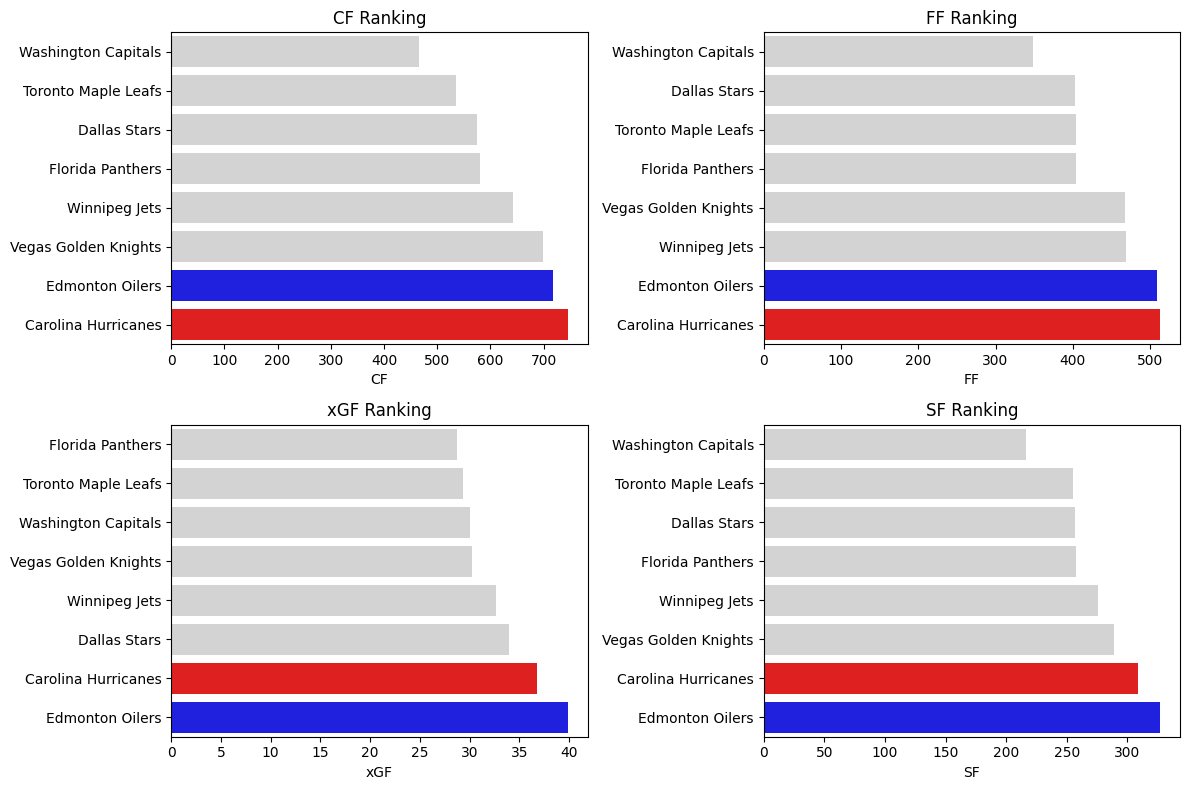

In [62]:
metrics = ['CF', 'FF', 'xGF', 'SF']
positions = [221, 222, 223, 224]  # 2x2 grid subplot positions

plt.figure(figsize=(12, 8))

for metric, pos in zip(metrics, positions):
    df_sorted = filter_2025.sort_values(metric)
    colors = df_sorted['Team'].map({'Edmonton Oilers': 'blue', 'Carolina Hurricanes': 'red'}).fillna('lightgray')

    plt.subplot(pos)
    sns.barplot(x=metric, y='Team', data=df_sorted, palette=colors)
    plt.title(f'{metric} Ranking')
    plt.xlabel(metric)
    plt.ylabel('')

plt.tight_layout()
plt.show()

These side by side individual metric rankings clearly show that **both the Edmonton Oilers and Carolina Hurricanes** consistently rank among the top playoff teams in terms of puck possession and offensive shot quality - key offensive stats correlating to Championship winning teams. This reinforces my conclusion that they are statistically dominant teams and supports their status as top Stanley Cup contenders in 2025.

**Overall,**
1. Top Predictive Stats: HDGF, xGF, GF, and SF emerged as the most important predictors of Cup-winning teams.
2. Winning teams consistently ranked higher in offensive pressure stats compared to non-winners.
3. Gradient Boosting slightly outperformed Logistic Regression in accuracy and feature interpretability.
4. Limitations: Only team-level playoff stats were used — future work could incorporate regular season data, defensive or player-level metrics.
5. Conclusion: There’s a measurable statistical edge for teams that dominate offensively in high-danger areas.

---
**Final prediction: Based on having consistently some of the highest composite scores, especially when combining shot volume, possession, and expected goals, as well as individual score ranking, coupled with overwhelmingly dominant performance in games, the Edmonton Oilers stand out as the most likely 2024‑25 Stanley Cup champions.** 

**This prediction has nothing at all to do with the fact that the Edmonton Oilers are my favorite team, that is merely a coincidence.**

<br>**🧡💙 Never in doubt! 💙🧡**